In [1]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

from sbi import analysis as analysis

# sbi
from sbi import utils as utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [2]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

### Hodgkin huxel model code ---

In [3]:
from scipy import stats as spstats


def syn_current(duration=120, dt=0.01, t_on=10, curr_level=5e-4, seed=None):
    duration = duration
    t_off = duration - t_on
    t = np.arange(0, duration + dt, dt)

    # external current
    A_soma = np.pi * ((70.0 * 1e-4) ** 2)  # cm2
    I_inj = np.zeros_like(t)
    I_inj[int(np.round(t_on / dt)) : int(np.round(t_off / dt))] = (
        curr_level / A_soma
    )  # muA/cm2

    return I_inj, t_on, t_off, dt, t, A_soma


def HHsimulator(V0, params, dt, t, I_inj, seed=None):
    """Simulates the Hodgkin-Huxley model for a specified time duration and current

    Parameters
    ----------
    V0 : float
        Voltage at first time step
    params : np.array, 1d of length dim_param
        Parameter vector
    dt : float
        Timestep
    t : array
        Numpy array with the time steps
    I : array
        Numpy array with the input current
    seed : int
    """

    gbar_Na = params[0, 0]  # mS/cm2
    gbar_Na.astype(float)
    gbar_K = params[0, 1]  # mS/cm2
    gbar_K.astype(float)

    # fixed parameters
    g_leak = 0.1  # mS/cm2
    gbar_M = 0.07  # mS/cm2
    tau_max = 6e2  # ms
    Vt = -60.0  # mV
    nois_fact = 0.1  # uA/cm2
    E_leak = -70.0  # mV
    C = 1.0  # uF/cm2
    E_Na = 53  # mV
    E_K = -107  # mV

    tstep = float(dt)

    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.0
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.0
        return 0.128 * np.exp(-v1 / 18.0)

    def beta_h(x):
        v1 = x - Vt - 40.0
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15.0
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.0
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return 1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return 1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return 1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.0
        return 1.0 / (1.0 + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.0
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros_like(t)  # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = (
            (m[i - 1] ** 3) * gbar_Na * h[i - 1]
            + (n[i - 1] ** 4) * gbar_K
            + g_leak
            + gbar_M * p[i - 1]
        ) / C
        V_inf = (
            (m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na
            + (n[i - 1] ** 4) * gbar_K * E_K
            + g_leak * E_leak
            + gbar_M * p[i - 1] * E_K
            + I_inj[i - 1]
            + nois_fact * rng.randn() / (tstep**0.5)
        ) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp(-tstep / tau_n(V[i]))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp(-tstep / tau_m(V[i]))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp(-tstep / tau_h(V[i]))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp(-tstep / tau_p(V[i]))

    return np.array(V).reshape(-1, 1)


def calculate_summary_statistics(x):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """
    I_inj, t_on, t_off, dt, t, A_soma = syn_current()

    n_mom = 4
    n_summary = 7

    n_summary = np.minimum(n_summary, n_mom + 3)

    t = x["time"]
    dt = x["dt"]

    # initialise array of spike counts
    v = np.array(x["data"])

    # put everything to -10 that is below -10 or has negative slope
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(v) < 0)
    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]

    # number of spikes
    if spike_times_stim.shape[0] > 0:
        spike_times_stim = spike_times_stim[
            np.append(1, np.diff(spike_times_stim)) > 0.5
        ]

    # resting potential and std
    rest_pot = np.mean(x["data"][t < t_on])
    rest_pot_std = np.std(x["data"][int(0.9 * t_on / dt) : int(t_on / dt)])

    # moments
    std_pw = np.power(
        np.std(x["data"][(t > t_on) & (t < t_off)]), np.linspace(3, n_mom, n_mom - 2)
    )
    std_pw = np.concatenate((np.ones(1), std_pw))
    moments = (
        spstats.moment(
            x["data"][(t > t_on) & (t < t_off)], np.linspace(2, n_mom, n_mom - 1)
        )
        / std_pw
    )

    # concatenation of summary statistics
    sum_stats_vec = np.concatenate((
        np.array([spike_times_stim.shape[0]]),
        np.array([
            rest_pot,
            rest_pot_std,
            np.mean(x["data"][(t > t_on) & (t < t_off)]),
        ]),
        moments,
    ))
    sum_stats_vec = sum_stats_vec[0:n_summary]

    return sum_stats_vec

### ---

In [5]:
# current, onset time of stimulation, offset time of stimulation, time step, time, area of some
I_inj, t_on, t_off, dt, t, A_soma = syn_current()

In [9]:
def run_HH_model(params):

    params = np.asarray(params)

    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1) * dt

    # initial voltage
    initial_voltage = -70

    voltage_trace = HHsimulator(initial_voltage, params.reshape(1, -1), dt, t, I)

    return dict(data=voltage_trace.reshape(-1), time=t, dt=dt, I_inj=I_inj.reshape(-1))

In [10]:
# three sets of (g_Na, g_K)
params = np.array([[50.0, 1.0], [4.0, 1.5], [20.0, 15.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(I_inj)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params=params[i, :])["data"]

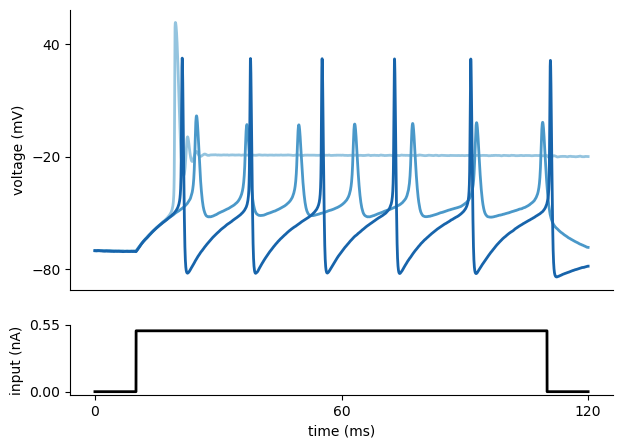

In [13]:
# colors for traces
col_min = 2
num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0 * i / num_colors) for i in range(col_min, num_colors)]

fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
# plot the three voltage traces for different parameter sets
for i in range(num_samples):
    plt.plot(t, sim_samples[i, :], color=col1[i], lw=2)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

# plot the injected current
ax = plt.subplot(gs[1])
plt.plot(t, I_inj * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t) / 2, max(t)])
ax.set_yticks([0, 1.1 * np.max(I_inj * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

In [15]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [16]:
prior_min = [0.5, 1e-4]
prior_max = [80.0, 15.0]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulation_wrapper = process_simulator(simulation_wrapper, prior, prior_returns_numpy)
check_sbi_inputs(simulation_wrapper, prior)

In [17]:
# Create inference object. Here, NPE is used.
inference = NPE(prior=prior)

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simulation_wrapper, proposal=prior,
                             num_simulations=300, num_workers=4)
inference = inference.append_simulations(theta, x)

# train the density estimator and build the posterior
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 671 epochs.

In [18]:
# true parameters and respective labels
true_params = np.array([50.0, 5.0])
labels_params = [r"$g_{Na}$", r"$g_{K}$"]

In [19]:
observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

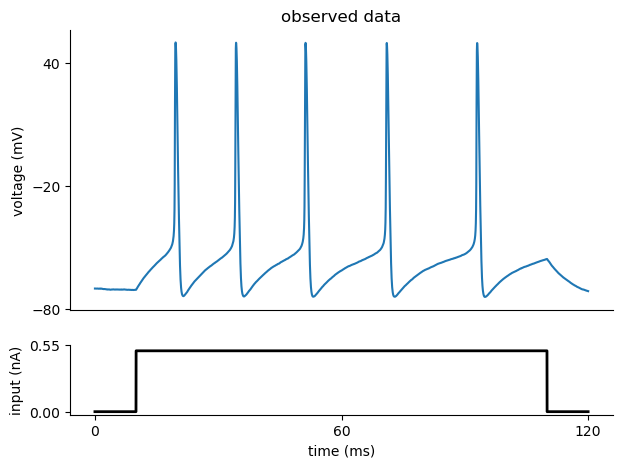

In [20]:
fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(observation_trace["time"], observation_trace["data"])
plt.ylabel("voltage (mV)")
plt.title("observed data")
plt.setp(ax, xticks=[], yticks=[-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(observation_trace["time"], I_inj * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(observation_trace["time"]) / 2, max(observation_trace["time"])])
ax.set_yticks([0, 1.1 * np.max(I_inj * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))

In [21]:
samples = posterior.sample((10000,), x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_9297/2944089099.py:1: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_offdiag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = analysis.pairplot(


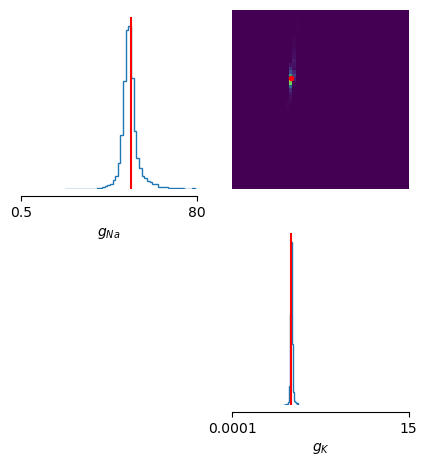

In [22]:
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.5, 80], [1e-4, 15.0]],
    ticks=[[0.5, 80], [1e-4, 15.0]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=labels_params,
);

In [23]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=observation_summary_statistics).numpy()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

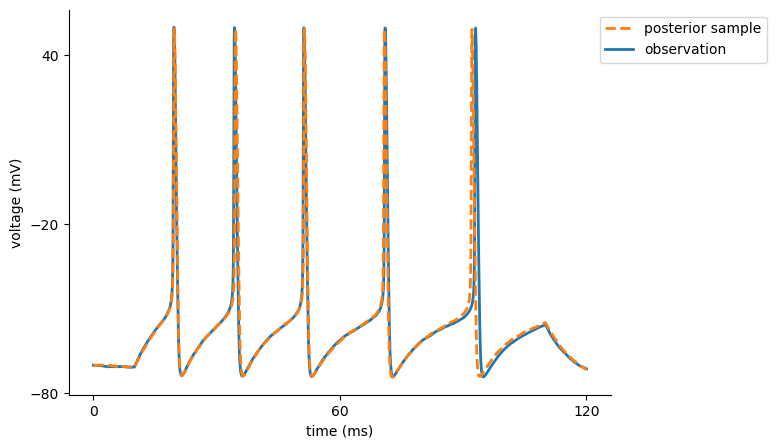

In [24]:
fig = plt.figure(figsize=(7, 5))

# plot observation
t = observation_trace["time"]
y_obs = observation_trace["data"]
plt.plot(t, y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x["data"], "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);